# Detecting BDM In Superbowl Commercials

In [152]:
import pandas as pd
import os

In [153]:

%pip install -r requirements.txt

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
ERROR: Cannot install charset-normalizer==3.4.0 and charset-normalizer==3.4.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested charset-normalizer==3.4.1
    The user requested charset-normalizer==3.4.1
    The user requested charset-normalizer==3.4.1
    The user requested charset-normalizer==3.4.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
You should consider upgrading via the '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/bin/python -m pip install --upgrade pip' command.
Note: you ma

In [154]:
INDUSTRY_SPECIFIC_AWARENESS = False
BRAND_SPECIFIC_AWARENESS = False

# Donwload Ads


In [155]:
def download_videos():
# Define the URL and the target directory
  url = 'https://box.fu-berlin.de/s/zwxKp8PXkCwAwGe/download'
  download_filename = 'downloaded_archive.zip'
  target_directory = 'ADs'

  # Step 1: Download the file
  os.system(f'wget -O {download_filename} {url}')

  # Step 2: Create the target directory if it doesn't exist
  os.makedirs(target_directory, exist_ok=True)

  # Step 3: Extract the downloaded archive to the target directory
  os.system(f'unzip -o {download_filename} -d {target_directory}')

  # Step 4: Remove the downloaded file
  os.remove(download_filename)

  print(f"Archive extracted to {target_directory} and {download_filename} removed.")

# Comment in to download the videos
# download_videos()

# Merge Excel Files

In [156]:
BDM_excel = pd.read_excel('BDM.xlsx')
final_excel = pd.read_excel('previous_project_results.xlsx')

In [157]:
final_excel = final_excel.merge(
    BDM_excel[['AdNumber', 'BDM']], 
    on='AdNumber', 
    how='left',
    suffixes=('_old', '')
).drop('BDM_old', axis=1, errors='ignore')


# print number of rows where BDM is NaN, 0 and 1
print(f"Number of rows where BDM is NaN: {final_excel[final_excel['BDM'].isna()].shape[0]}")
print(f"Number of rows where BDM is 0: {final_excel[final_excel['BDM'] == 0].shape[0]}")
print(f"Number of rows where BDM is 1: {final_excel[final_excel['BDM'] == 1].shape[0]}")


Number of rows where BDM is NaN: 22
Number of rows where BDM is 0: 411
Number of rows where BDM is 1: 139


In [158]:
ad_df = final_excel.groupby(['cont_primary_product_type', 'BRAND', 'AdNumber', "BDM"]).size().reset_index(name='count')
ad_df.rename(columns={'cont_primary_product_type': 'product_category', 'BRAND': 'brand', 'AdNumber': 'commercial_number'}, inplace=True)
ad_df.drop(columns=['count'], inplace=True)
ad_df.head(10)

,product_category,brand,commercial_number,BDM
0,1.0,AvocadosfromMexico,AD0357,0.0
1,1.0,AvocadosfromMexico,AD0414,1.0
2,1.0,AvocadosfromMexico,AD0474,0.0
3,1.0,AvocadosfromMexico,AD0525,1.0
4,1.0,AvocadosfromMexico,AD0584,1.0
5,1.0,AvocadosfromMexico,AD0635,1.0
6,1.0,AvocadosfromMexico,AD0745,0.0
7,1.0,BUBLY,AD0586,1.0
8,1.0,Bai,AD0475,0.0
9,1.0,Butterfinger,AD0420,1.0


### Brand Keywords

In [159]:
if BRAND_SPECIFIC_AWARENESS:
    product_brand_df = pd.read_csv("product_brands.csv")

    product_brand_df['brand'] = product_brand_df['brand'].str.replace(' ', '').str.lower()
    ad_df['brand_clean'] = ad_df['brand'].str.replace(' ', '').str.lower()

    # Merge the dataframes
    ad_df = ad_df.merge(
        product_brand_df[['brand', 'product_brand_keywords']], 
        left_on='brand_clean',
        right_on='brand',
        how='left',
        suffixes=('', '_brand')
    )

    # Clean up columns
    ad_df.drop(['brand_clean', 'brand_brand'], axis=1, inplace=True)


    ad_df.head(10)

### Product Category Keywords

In [160]:
if INDUSTRY_SPECIFIC_AWARENESS:
    product_brands_df = pd.read_csv("product_categories.csv")
    product_brands_df.head(40)
    product_brands_df = product_brands_df.drop('product_cat_id', axis=1)
    ad_df = ad_df.drop('product_category', axis=1)
    display(product_brands_df)
    display(ad_df)

    # Create a dictionary to map brands to their product categories and other attributes
    brand_to_info = {}
    for _, row in product_brands_df.iterrows():
        # Convert string representation of list to actual list
        brands = eval(row['product_cat_brands'])
        for brand in brands:
            # Remove spaces and convert to lowercase for more robust matching
            brand = brand.replace(' ', '').lower()
            # Store all columns for this brand
            brand_to_info[brand] = {col: row[col] for col in product_brands_df.columns}

    # Function to find category info for a brand
    def find_brand_info(brand):
        # Clean brand name for matching
        clean_brand = brand.replace(' ', '').lower()
        return brand_to_info.get(clean_brand)

    # Add all product category columns to ad_df
    for col in product_brands_df.columns:
        ad_df[col] = ad_df['brand'].apply(lambda x: find_brand_info(x)[col] if find_brand_info(x) else None)

    # Print brands that couldn't be mapped
    unmapped_brands = ad_df[ad_df['product_cat_name'].isna()]['brand'].unique()
    if len(unmapped_brands) > 0:
        print("Brands without category mapping:")
        for brand in unmapped_brands:
            print(f"- {brand}")

    # Print number of rows with missing category
    print(f"Number of rows where product category is NaN: {ad_df[ad_df['product_cat_name'].isna()].shape[0]}")


    print(f"Final number of rows with missing categories: {ad_df[ad_df['product_cat_name'].isna()].shape[0]}")

    ad_df.head(10)

In [161]:
ad_df = ad_df.dropna()
# TODO: Implement proper handling of missing values
# TODO: Remove this line
if BRAND_SPECIFIC_AWARENESS or INDUSTRY_SPECIFIC_AWARENESS:
  ad_df = ad_df.head(5)
else:
  ad_df = ad_df.head(20)
display(ad_df)

# save progress so far to csv
# make csv dir if it doesn't exist
os.makedirs('csvs', exist_ok=True)
ad_df.to_csv('csvs/1_ad_df_baseline.csv', index=False)

,product_category,brand,commercial_number,BDM
0,1.0,AvocadosfromMexico,AD0357,0.0
1,1.0,AvocadosfromMexico,AD0414,1.0
2,1.0,AvocadosfromMexico,AD0474,0.0
3,1.0,AvocadosfromMexico,AD0525,1.0
4,1.0,AvocadosfromMexico,AD0584,1.0
5,1.0,AvocadosfromMexico,AD0635,1.0
6,1.0,AvocadosfromMexico,AD0745,0.0
7,1.0,BUBLY,AD0586,1.0
8,1.0,Bai,AD0475,0.0
9,1.0,Butterfinger,AD0420,1.0


## Retrieving Transcript

In [162]:
ad_df = pd.read_csv('csvs/1_ad_df_baseline.csv')

In [163]:
import glob
from pathlib import Path
from transcript import transcribe_video

ads_dir = "ADs"

def find_video_file(commercial_number, ads_dir):
    """Find the video file path for a given commercial number."""
    # Search recursively for MP4 files
    pattern = f"{ads_dir}/**/{commercial_number}.mp4"
    matches = glob.glob(pattern, recursive=True)
    return matches[0] if matches else None

# Create transcript column
ad_df['transcript'] = ''

# Process each commercial
for idx, row in ad_df.iterrows():
    commercial_number = row['commercial_number']
    video_path = find_video_file(commercial_number, ads_dir)
    
    if video_path:
        transcript = transcribe_video(video_path)
        ad_df.at[idx, 'transcript'] = transcript
    else:
        print(f"Video not found for commercial {commercial_number}")

ad_df[ad_df['transcript'].notna()]
ad_df["audio_only_transcript"] = ad_df["transcript"]
ad_df.head(10)

Video not found for commercial AD0760


,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript
0,1.0,AvocadosfromMexico,AD0357,0.0,"With an ex-pick in the first draft ever, Aust...","With an ex-pick in the first draft ever, Aust..."
1,1.0,AvocadosfromMexico,AD0414,1.0,Over here we have the cube of Rubik. This sim...,Over here we have the cube of Rubik. This sim...
2,1.0,AvocadosfromMexico,AD0474,0.0,"Guys, how can we be a secret society if we ca...","Guys, how can we be a secret society if we ca..."
3,1.0,AvocadosfromMexico,AD0525,1.0,"Well, we didn't. We sealed the bad out and ke...","Well, we didn't. We sealed the bad out and ke..."
4,1.0,AvocadosfromMexico,AD0584,1.0,"Pagentry, poise, welcome to the Doge Show whe...","Pagentry, poise, welcome to the Doge Show whe..."
5,1.0,AvocadosfromMexico,AD0635,1.0,Welcome to the Avocado's for Mexico shopping ...,Welcome to the Avocado's for Mexico shopping ...
6,1.0,AvocadosfromMexico,AD0745,0.0,This is officially the worst day I'll get eve...,This is officially the worst day I'll get eve...
7,1.0,BUBLY,AD0586,1.0,"Ooh, like very boobly. My favorite. You mean ...","Ooh, like very boobly. My favorite. You mean ..."
8,1.0,Bai,AD0475,0.0,I don't know how I get tough. I just want to ...,I don't know how I get tough. I just want to ...
9,1.0,Butterfinger,AD0420,1.0,A bull rider is bold. Now a bull rider on a c...,A bull rider is bold. Now a bull rider on a c...


In [164]:

ad_df.to_csv('csvs/2_ad_df_transcript.csv', index=False)

## Adding OCR Text

In [165]:
ad_df = pd.read_csv('csvs/2_ad_df_transcript.csv')

In [166]:

# from ocr import ocr

In [167]:


ad_df['ocr_text'] = ''

ad_df.drop(columns=['ocr_text'], inplace=True)
for idx, row in ad_df.iterrows():
    transcript = row['transcript']

    ad_df.at[idx, 'ocr_text'] = 'NOT IMPLEMENTED YET'
    # TODO Uncomment the line below to run OCR on the transcript
    # ad_df.at[idx, 'ocr_text'] = ocr(transcript)

ad_df["audio_only_transcript"] = ad_df["transcript"]
ad_df['transcript'] = ad_df['ocr_text'] + ' ' + ad_df['transcript']
ad_df.head(10)


ad_df.to_csv('csvs/3_ad_df_ocr.csv', index=False)


In [168]:
!python -m spacy download en_core_web_sm


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
You should consider upgrading via the '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Determining Frequency of Superlatives and Comparative Adjectives

In [169]:

ad_df = pd.read_csv('csvs/3_ad_df_ocr.csv')

In [170]:
import spacy
import pandas as pd
from collections import Counter
import text_analysis as ta

# Create new columns to store the counts and percentages
ad_df['word_count'] = 0
ad_df['superlative_count'] = 0
ad_df['comparative_count'] = 0
ad_df['uniqueness_count'] = 0
ad_df['superlative_pct'] = 0.0
ad_df['comparative_pct'] = 0.0
ad_df['uniqueness_pct'] = 0.0
ad_df['total_bdm_terms_count'] = 0
ad_df['total_bdm_terms_pct'] = 0.0

# Process each row
for idx, row in ad_df.iterrows():
    word_count = len(ta.get_tokens(row['transcript']))
    ad_df.at[idx, 'word_count'] = word_count

    superlatives = ta.get_superlatives(row['transcript'])
    ad_df.at[idx, 'superlatives'] = ', '.join(superlatives) if superlatives else ''
    superlative_count = len(superlatives) if superlatives else 0
    ad_df.at[idx, 'superlative_count'] = superlative_count

    comparatives = ta.get_comparatives(row['transcript'])
    ad_df.at[idx, 'comparatives'] = ', '.join(comparatives) if comparatives else ''
    comparative_count = len(comparatives) if comparatives else 0
    ad_df.at[idx, 'comparative_count'] = comparative_count
    
    unique_words = ta.get_unique_words(row['transcript'])
    ad_df.at[idx, 'unique_words'] = ', '.join(unique_words) if unique_words else ''
    uniqueness_count = len(unique_words) if unique_words else 0
    ad_df.at[idx, 'uniqueness_count'] = uniqueness_count

    if word_count > 0:
        ad_df.at[idx, 'superlative_pct'] = superlative_count / word_count * 100
        ad_df.at[idx, 'comparative_pct'] = comparative_count / word_count * 100
        ad_df.at[idx, 'uniqueness_pct'] = uniqueness_count / word_count * 100
        
        total_bdm_terms = superlative_count + comparative_count + uniqueness_count
        ad_df.at[idx, 'total_bdm_terms_count'] = total_bdm_terms
        ad_df.at[idx, 'total_bdm_terms_pct'] = total_bdm_terms / word_count * 100

# Sort the DataFrame
ad_df = ad_df.sort_values(
    by=['superlative_count', 'comparative_count', 'superlative_pct', 'comparative_pct', 'uniqueness_pct'],
    ascending=[False, False, False, False, False]
)

# Display top 10 results
ad_df.head(10)

,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,superlative_pct,comparative_pct,uniqueness_pct,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words
3,1.0,AvocadosfromMexico,AD0525,1.0,"NOT IMPLEMENTED YET Well, we didn't. We seale...","Well, we didn't. We sealed the bad out and ke...",NOT IMPLEMENTED YET,98,1,0,0,1.020408,0.000000,0.000000,1,1.020408,hottest,,
6,1.0,AvocadosfromMexico,AD0745,0.0,NOT IMPLEMENTED YET This is officially the wo...,This is officially the worst day I'll get eve...,NOT IMPLEMENTED YET,118,1,0,0,0.847458,0.000000,0.000000,1,0.847458,worst,,
2,1.0,AvocadosfromMexico,AD0474,0.0,"NOT IMPLEMENTED YET Guys, how can we be a sec...","Guys, how can we be a secret society if we ca...",NOT IMPLEMENTED YET,125,1,0,1,0.800000,0.000000,0.800000,2,1.600000,least,,only
9,1.0,Butterfinger,AD0420,1.0,NOT IMPLEMENTED YET A bull rider is bold. Now...,A bull rider is bold. Now a bull rider on a c...,NOT IMPLEMENTED YET,115,0,9,0,0.000000,7.826087,0.000000,9,7.826087,,"bolder, bolder, bolder, bolder, bolder, bolder...",
5,1.0,AvocadosfromMexico,AD0635,1.0,NOT IMPLEMENTED YET Welcome to the Avocado's ...,Welcome to the Avocado's for Mexico shopping ...,NOT IMPLEMENTED YET,136,0,1,0,0.000000,0.735294,0.000000,1,0.735294,,closer,
12,1.0,Cheetos,AD0694,0.0,NOT IMPLEMENTED YET Did you steal my cheetos ...,Did you steal my cheetos again? Just tell the...,NOT IMPLEMENTED YET,157,0,1,1,0.000000,0.636943,0.636943,2,1.273885,,lesser,first
0,1.0,AvocadosfromMexico,AD0357,0.0,NOT IMPLEMENTED YET With an ex-pick in the fi...,"With an ex-pick in the first draft ever, Aust...",NOT IMPLEMENTED YET,80,0,0,2,0.000000,0.000000,2.500000,2,2.500000,,,"first, original"
14,1.0,Chobani,AD0314,0.0,NOT IMPLEMENTED YET How are you doing today? ...,How are you doing today? Yeah. Woo! Woo! Woo!...,NOT IMPLEMENTED YET,103,0,0,2,0.000000,0.000000,1.941748,2,1.941748,,,"only, only"
4,1.0,AvocadosfromMexico,AD0584,1.0,"NOT IMPLEMENTED YET Pagentry, poise, welcome ...","Pagentry, poise, welcome to the Doge Show whe...",NOT IMPLEMENTED YET,110,0,0,1,0.000000,0.000000,0.909091,1,0.909091,,,ultimate
1,1.0,AvocadosfromMexico,AD0414,1.0,NOT IMPLEMENTED YET Over here we have the cub...,Over here we have the cube of Rubik. This sim...,NOT IMPLEMENTED YET,106,0,0,0,0.000000,0.000000,0.000000,0,0.000000,,,


In [171]:
# remove superlatives, comparatives and unique_words from ad_df
ad_df.drop(columns=['comparative_pct', 'superlative_pct', 'uniqueness_pct'], inplace=True)
ad_df.head(10)


,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words
3,1.0,AvocadosfromMexico,AD0525,1.0,"NOT IMPLEMENTED YET Well, we didn't. We seale...","Well, we didn't. We sealed the bad out and ke...",NOT IMPLEMENTED YET,98,1,0,0,1,1.020408,hottest,,
6,1.0,AvocadosfromMexico,AD0745,0.0,NOT IMPLEMENTED YET This is officially the wo...,This is officially the worst day I'll get eve...,NOT IMPLEMENTED YET,118,1,0,0,1,0.847458,worst,,
2,1.0,AvocadosfromMexico,AD0474,0.0,"NOT IMPLEMENTED YET Guys, how can we be a sec...","Guys, how can we be a secret society if we ca...",NOT IMPLEMENTED YET,125,1,0,1,2,1.600000,least,,only
9,1.0,Butterfinger,AD0420,1.0,NOT IMPLEMENTED YET A bull rider is bold. Now...,A bull rider is bold. Now a bull rider on a c...,NOT IMPLEMENTED YET,115,0,9,0,9,7.826087,,"bolder, bolder, bolder, bolder, bolder, bolder...",
5,1.0,AvocadosfromMexico,AD0635,1.0,NOT IMPLEMENTED YET Welcome to the Avocado's ...,Welcome to the Avocado's for Mexico shopping ...,NOT IMPLEMENTED YET,136,0,1,0,1,0.735294,,closer,
12,1.0,Cheetos,AD0694,0.0,NOT IMPLEMENTED YET Did you steal my cheetos ...,Did you steal my cheetos again? Just tell the...,NOT IMPLEMENTED YET,157,0,1,1,2,1.273885,,lesser,first
0,1.0,AvocadosfromMexico,AD0357,0.0,NOT IMPLEMENTED YET With an ex-pick in the fi...,"With an ex-pick in the first draft ever, Aust...",NOT IMPLEMENTED YET,80,0,0,2,2,2.500000,,,"first, original"
14,1.0,Chobani,AD0314,0.0,NOT IMPLEMENTED YET How are you doing today? ...,How are you doing today? Yeah. Woo! Woo! Woo!...,NOT IMPLEMENTED YET,103,0,0,2,2,1.941748,,,"only, only"
4,1.0,AvocadosfromMexico,AD0584,1.0,"NOT IMPLEMENTED YET Pagentry, poise, welcome ...","Pagentry, poise, welcome to the Doge Show whe...",NOT IMPLEMENTED YET,110,0,0,1,1,0.909091,,,ultimate
1,1.0,AvocadosfromMexico,AD0414,1.0,NOT IMPLEMENTED YET Over here we have the cub...,Over here we have the cube of Rubik. This sim...,NOT IMPLEMENTED YET,106,0,0,0,0,0.000000,,,


## Nomen + Adjektive

In [172]:
# Apply the function to each transcript individually using pandas apply
ad_df["adj_noun_pairs"] = ad_df["transcript"].apply(ta.extract_adj_noun_pairs)

# Add a column for the number of adjective-noun pairs
ad_df["num_adj_noun_pairs"] = ad_df["adj_noun_pairs"].apply(len)

# Display the first 10 rows of the DataFrame
display(ad_df.head(10))

,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
3,1.0,AvocadosfromMexico,AD0525,1.0,"NOT IMPLEMENTED YET Well, we didn't. We seale...","Well, we didn't. We sealed the bad out and ke...",NOT IMPLEMENTED YET,98,1,0,0,1,1.020408,hottest,,,[],0
6,1.0,AvocadosfromMexico,AD0745,0.0,NOT IMPLEMENTED YET This is officially the wo...,This is officially the worst day I'll get eve...,NOT IMPLEMENTED YET,118,1,0,0,1,0.847458,worst,,,"[worst day, ox cart, great time]",3
2,1.0,AvocadosfromMexico,AD0474,0.0,"NOT IMPLEMENTED YET Guys, how can we be a sec...","Guys, how can we be a secret society if we ca...",NOT IMPLEMENTED YET,125,1,0,1,2,1.600000,least,,only,"[secret society, good fat, secret society, sub...",4
9,1.0,Butterfinger,AD0420,1.0,NOT IMPLEMENTED YET A bull rider is bold. Now...,A bull rider is bold. Now a bull rider on a c...,NOT IMPLEMENTED YET,115,0,9,0,9,7.826087,,"bolder, bolder, bolder, bolder, bolder, bolder...",,[crunchy peanut],1
5,1.0,AvocadosfromMexico,AD0635,1.0,NOT IMPLEMENTED YET Welcome to the Avocado's ...,Welcome to the Avocado's for Mexico shopping ...,NOT IMPLEMENTED YET,136,0,1,0,1,0.735294,,closer,,"[avocado carrier, new travel]",2
12,1.0,Cheetos,AD0694,0.0,NOT IMPLEMENTED YET Did you steal my cheetos ...,Did you steal my cheetos again? Just tell the...,NOT IMPLEMENTED YET,157,0,1,1,2,1.273885,,lesser,first,[first time],1
0,1.0,AvocadosfromMexico,AD0357,0.0,NOT IMPLEMENTED YET With an ex-pick in the fi...,"With an ex-pick in the first draft ever, Aust...",NOT IMPLEMENTED YET,80,0,0,2,2,2.500000,,,"first, original","[first draft, ideal year]",2
14,1.0,Chobani,AD0314,0.0,NOT IMPLEMENTED YET How are you doing today? ...,How are you doing today? Yeah. Woo! Woo! Woo!...,NOT IMPLEMENTED YET,103,0,0,2,2,1.941748,,,"only, only","[natural ingredients, only way]",2
4,1.0,AvocadosfromMexico,AD0584,1.0,"NOT IMPLEMENTED YET Pagentry, poise, welcome ...","Pagentry, poise, welcome to the Doge Show whe...",NOT IMPLEMENTED YET,110,0,0,1,1,0.909091,,,ultimate,"[ultimate prize, good sit]",2
1,1.0,AvocadosfromMexico,AD0414,1.0,NOT IMPLEMENTED YET Over here we have the cub...,Over here we have the cube of Rubik. This sim...,NOT IMPLEMENTED YET,106,0,0,0,0,0.000000,,,,"[simple puzzle, 21st century, civil war]",3


In [173]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from collections import defaultdict

nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]  

True

In [174]:
# Process each transcript
import numpy as np
if INDUSTRY_SPECIFIC_AWARENESS:
    for idx, row in ad_df.iterrows():
        transcript = row['transcript']
        product_cat_keyword_similarities = {}
        for keyword in row['product_cat_keywords'][1:-1].replace("'", "").split(", "):
            similarity = round(float(ta.get_semantic_similarity(transcript, keyword)), 3)
            product_cat_keyword_similarities[keyword] = similarity
        
        sorted_keywords = sorted(product_cat_keyword_similarities.items(), key=lambda x: x[1], reverse=True)
        top_3_keywords = sorted_keywords[:3]
        top_3_average = round(float(np.mean([sim for _, sim in top_3_keywords])), 3)
        
        print(f"\nTranscript {row['commercial_number']}:")
        print(f"Top 3 keywords:")
        for keyword, similarity in top_3_keywords:
            print(f"- {keyword}: {similarity}")
        print(f"Top 3 average similarity: {top_3_average}")
        
        ad_df.at[idx, 'product_cat_keyword_similarity'] = top_3_average
        ad_df.at[idx, 'product_cat_top_keywords'] = ', '.join([keyword for keyword, _ in top_3_keywords])
if BRAND_SPECIFIC_AWARENESS:
    for idx, row in ad_df.iterrows():
        transcript = row['transcript']
        product_brand_keyword_similarities = {}
        
        for keyword in row['product_brand_keywords'][1:-1].replace("'", "").split(", "):
            similarity = round(float(ta.get_semantic_similarity(transcript, keyword)), 3)
            product_brand_keyword_similarities[keyword] = similarity
        
        sorted_keywords = sorted(product_brand_keyword_similarities.items(), key=lambda x: x[1], reverse=True)
        top_3_keywords = sorted_keywords[:3]
        top_3_average = round(float(np.mean([sim for _, sim in top_3_keywords])), 3)
        
        print(f"\nTranscript {row['commercial_number']}:")
        print(f"Top 3 brand keywords:")
        for keyword, similarity in top_3_keywords:
            print(f"- {keyword}: {similarity}")
        print(f"Top 3 average brand similarity: {top_3_average}")
        
        ad_df.at[idx, 'product_brand_keyword_similarity'] = top_3_average
        ad_df.at[idx, 'product_brand_top_keywords'] = ', '.join([keyword for keyword, _ in top_3_keywords])

In [175]:

ad_df.to_csv('csvs/4_ad_df_keywords.csv', index=False)

In [176]:
import pandas as pd
ad_df = pd.read_csv('csvs/4_ad_df_keywords.csv')

In [177]:


ad_df[ad_df.isnull().any(axis=1)].head()
ad_df[ad_df.isna().any(axis=1)].head()

ad_df = ad_df[ad_df['transcript'] != '']
ad_df = ad_df[ad_df['transcript'] != '']

# print all from ad_df with empty values
display(ad_df[ad_df.isnull().any(axis=1)])
display(ad_df[ad_df.isna().any(axis=1)])

,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0525,1.0,"NOT IMPLEMENTED YET Well, we didn't. We seale...","Well, we didn't. We sealed the bad out and ke...",NOT IMPLEMENTED YET,98,1,0,0,1,1.020408,hottest,NaN,NaN,[],0
1,1.0,AvocadosfromMexico,AD0745,0.0,NOT IMPLEMENTED YET This is officially the wo...,This is officially the worst day I'll get eve...,NOT IMPLEMENTED YET,118,1,0,0,1,0.847458,worst,NaN,NaN,"['worst day', 'ox cart', 'great time']",3
2,1.0,AvocadosfromMexico,AD0474,0.0,"NOT IMPLEMENTED YET Guys, how can we be a sec...","Guys, how can we be a secret society if we ca...",NOT IMPLEMENTED YET,125,1,0,1,2,1.600000,least,NaN,only,"['secret society', 'good fat', 'secret society...",4
3,1.0,Butterfinger,AD0420,1.0,NOT IMPLEMENTED YET A bull rider is bold. Now...,A bull rider is bold. Now a bull rider on a c...,NOT IMPLEMENTED YET,115,0,9,0,9,7.826087,NaN,"bolder, bolder, bolder, bolder, bolder, bolder...",NaN,['crunchy peanut'],1
4,1.0,AvocadosfromMexico,AD0635,1.0,NOT IMPLEMENTED YET Welcome to the Avocado's ...,Welcome to the Avocado's for Mexico shopping ...,NOT IMPLEMENTED YET,136,0,1,0,1,0.735294,NaN,closer,NaN,"['avocado carrier', 'new travel']",2
5,1.0,Cheetos,AD0694,0.0,NOT IMPLEMENTED YET Did you steal my cheetos ...,Did you steal my cheetos again? Just tell the...,NOT IMPLEMENTED YET,157,0,1,1,2,1.273885,NaN,lesser,first,['first time'],1
6,1.0,AvocadosfromMexico,AD0357,0.0,NOT IMPLEMENTED YET With an ex-pick in the fi...,"With an ex-pick in the first draft ever, Aust...",NOT IMPLEMENTED YET,80,0,0,2,2,2.500000,NaN,NaN,"first, original","['first draft', 'ideal year']",2
7,1.0,Chobani,AD0314,0.0,NOT IMPLEMENTED YET How are you doing today? ...,How are you doing today? Yeah. Woo! Woo! Woo!...,NOT IMPLEMENTED YET,103,0,0,2,2,1.941748,NaN,NaN,"only, only","['natural ingredients', 'only way']",2
8,1.0,AvocadosfromMexico,AD0584,1.0,"NOT IMPLEMENTED YET Pagentry, poise, welcome ...","Pagentry, poise, welcome to the Doge Show whe...",NOT IMPLEMENTED YET,110,0,0,1,1,0.909091,NaN,NaN,ultimate,"['ultimate prize', 'good sit']",2
9,1.0,AvocadosfromMexico,AD0414,1.0,NOT IMPLEMENTED YET Over here we have the cub...,Over here we have the cube of Rubik. This sim...,NOT IMPLEMENTED YET,106,0,0,0,0,0.000000,NaN,NaN,NaN,"['simple puzzle', '21st century', 'civil war']",3


,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0525,1.0,"NOT IMPLEMENTED YET Well, we didn't. We seale...","Well, we didn't. We sealed the bad out and ke...",NOT IMPLEMENTED YET,98,1,0,0,1,1.020408,hottest,NaN,NaN,[],0
1,1.0,AvocadosfromMexico,AD0745,0.0,NOT IMPLEMENTED YET This is officially the wo...,This is officially the worst day I'll get eve...,NOT IMPLEMENTED YET,118,1,0,0,1,0.847458,worst,NaN,NaN,"['worst day', 'ox cart', 'great time']",3
2,1.0,AvocadosfromMexico,AD0474,0.0,"NOT IMPLEMENTED YET Guys, how can we be a sec...","Guys, how can we be a secret society if we ca...",NOT IMPLEMENTED YET,125,1,0,1,2,1.600000,least,NaN,only,"['secret society', 'good fat', 'secret society...",4
3,1.0,Butterfinger,AD0420,1.0,NOT IMPLEMENTED YET A bull rider is bold. Now...,A bull rider is bold. Now a bull rider on a c...,NOT IMPLEMENTED YET,115,0,9,0,9,7.826087,NaN,"bolder, bolder, bolder, bolder, bolder, bolder...",NaN,['crunchy peanut'],1
4,1.0,AvocadosfromMexico,AD0635,1.0,NOT IMPLEMENTED YET Welcome to the Avocado's ...,Welcome to the Avocado's for Mexico shopping ...,NOT IMPLEMENTED YET,136,0,1,0,1,0.735294,NaN,closer,NaN,"['avocado carrier', 'new travel']",2
5,1.0,Cheetos,AD0694,0.0,NOT IMPLEMENTED YET Did you steal my cheetos ...,Did you steal my cheetos again? Just tell the...,NOT IMPLEMENTED YET,157,0,1,1,2,1.273885,NaN,lesser,first,['first time'],1
6,1.0,AvocadosfromMexico,AD0357,0.0,NOT IMPLEMENTED YET With an ex-pick in the fi...,"With an ex-pick in the first draft ever, Aust...",NOT IMPLEMENTED YET,80,0,0,2,2,2.500000,NaN,NaN,"first, original","['first draft', 'ideal year']",2
7,1.0,Chobani,AD0314,0.0,NOT IMPLEMENTED YET How are you doing today? ...,How are you doing today? Yeah. Woo! Woo! Woo!...,NOT IMPLEMENTED YET,103,0,0,2,2,1.941748,NaN,NaN,"only, only","['natural ingredients', 'only way']",2
8,1.0,AvocadosfromMexico,AD0584,1.0,"NOT IMPLEMENTED YET Pagentry, poise, welcome ...","Pagentry, poise, welcome to the Doge Show whe...",NOT IMPLEMENTED YET,110,0,0,1,1,0.909091,NaN,NaN,ultimate,"['ultimate prize', 'good sit']",2
9,1.0,AvocadosfromMexico,AD0414,1.0,NOT IMPLEMENTED YET Over here we have the cub...,Over here we have the cube of Rubik. This sim...,NOT IMPLEMENTED YET,106,0,0,0,0,0.000000,NaN,NaN,NaN,"['simple puzzle', '21st century', 'civil war']",3


In [178]:
ad_df.head(20)

,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0525,1.0,"NOT IMPLEMENTED YET Well, we didn't. We seale...","Well, we didn't. We sealed the bad out and ke...",NOT IMPLEMENTED YET,98,1,0,0,1,1.020408,hottest,NaN,NaN,[],0
1,1.0,AvocadosfromMexico,AD0745,0.0,NOT IMPLEMENTED YET This is officially the wo...,This is officially the worst day I'll get eve...,NOT IMPLEMENTED YET,118,1,0,0,1,0.847458,worst,NaN,NaN,"['worst day', 'ox cart', 'great time']",3
2,1.0,AvocadosfromMexico,AD0474,0.0,"NOT IMPLEMENTED YET Guys, how can we be a sec...","Guys, how can we be a secret society if we ca...",NOT IMPLEMENTED YET,125,1,0,1,2,1.600000,least,NaN,only,"['secret society', 'good fat', 'secret society...",4
3,1.0,Butterfinger,AD0420,1.0,NOT IMPLEMENTED YET A bull rider is bold. Now...,A bull rider is bold. Now a bull rider on a c...,NOT IMPLEMENTED YET,115,0,9,0,9,7.826087,NaN,"bolder, bolder, bolder, bolder, bolder, bolder...",NaN,['crunchy peanut'],1
4,1.0,AvocadosfromMexico,AD0635,1.0,NOT IMPLEMENTED YET Welcome to the Avocado's ...,Welcome to the Avocado's for Mexico shopping ...,NOT IMPLEMENTED YET,136,0,1,0,1,0.735294,NaN,closer,NaN,"['avocado carrier', 'new travel']",2
5,1.0,Cheetos,AD0694,0.0,NOT IMPLEMENTED YET Did you steal my cheetos ...,Did you steal my cheetos again? Just tell the...,NOT IMPLEMENTED YET,157,0,1,1,2,1.273885,NaN,lesser,first,['first time'],1
6,1.0,AvocadosfromMexico,AD0357,0.0,NOT IMPLEMENTED YET With an ex-pick in the fi...,"With an ex-pick in the first draft ever, Aust...",NOT IMPLEMENTED YET,80,0,0,2,2,2.500000,NaN,NaN,"first, original","['first draft', 'ideal year']",2
7,1.0,Chobani,AD0314,0.0,NOT IMPLEMENTED YET How are you doing today? ...,How are you doing today? Yeah. Woo! Woo! Woo!...,NOT IMPLEMENTED YET,103,0,0,2,2,1.941748,NaN,NaN,"only, only","['natural ingredients', 'only way']",2
8,1.0,AvocadosfromMexico,AD0584,1.0,"NOT IMPLEMENTED YET Pagentry, poise, welcome ...","Pagentry, poise, welcome to the Doge Show whe...",NOT IMPLEMENTED YET,110,0,0,1,1,0.909091,NaN,NaN,ultimate,"['ultimate prize', 'good sit']",2
9,1.0,AvocadosfromMexico,AD0414,1.0,NOT IMPLEMENTED YET Over here we have the cub...,Over here we have the cube of Rubik. This sim...,NOT IMPLEMENTED YET,106,0,0,0,0,0.000000,NaN,NaN,NaN,"['simple puzzle', '21st century', 'civil war']",3


In [179]:
# Calculate the minimum number of samples in each group
# 
min_samples = min(len(ad_df[ad_df['BDM'] == 1]), len(ad_df[ad_df['BDM'] == 0]))
nn_df = ad_df
# Perform undersampling
ad_df_balanced = pd.concat([
    ad_df[ad_df['BDM'] == 1].sample(n=min_samples, random_state=42),
    ad_df[ad_df['BDM'] == 0].sample(n=min_samples, random_state=42)
]).reset_index(drop=True)

# Print the results
print(f"Total rows: {len(ad_df_balanced)}")
print(f"Rows with BDM = 1.0: {len(ad_df_balanced[ad_df_balanced['BDM'] == 1.0])}")
print(f"Rows with BDM = 0.0: {len(ad_df_balanced[ad_df_balanced['BDM'] == 0.0])}")



commercial_numbers = ad_df_balanced['commercial_number']

# TODO: remove the following line after testing
ad_df_balanced = ad_df

ad_df_balanced.head(20)

Total rows: 12
Rows with BDM = 1.0: 6
Rows with BDM = 0.0: 6


,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0525,1.0,"NOT IMPLEMENTED YET Well, we didn't. We seale...","Well, we didn't. We sealed the bad out and ke...",NOT IMPLEMENTED YET,98,1,0,0,1,1.020408,hottest,NaN,NaN,[],0
1,1.0,AvocadosfromMexico,AD0745,0.0,NOT IMPLEMENTED YET This is officially the wo...,This is officially the worst day I'll get eve...,NOT IMPLEMENTED YET,118,1,0,0,1,0.847458,worst,NaN,NaN,"['worst day', 'ox cart', 'great time']",3
2,1.0,AvocadosfromMexico,AD0474,0.0,"NOT IMPLEMENTED YET Guys, how can we be a sec...","Guys, how can we be a secret society if we ca...",NOT IMPLEMENTED YET,125,1,0,1,2,1.600000,least,NaN,only,"['secret society', 'good fat', 'secret society...",4
3,1.0,Butterfinger,AD0420,1.0,NOT IMPLEMENTED YET A bull rider is bold. Now...,A bull rider is bold. Now a bull rider on a c...,NOT IMPLEMENTED YET,115,0,9,0,9,7.826087,NaN,"bolder, bolder, bolder, bolder, bolder, bolder...",NaN,['crunchy peanut'],1
4,1.0,AvocadosfromMexico,AD0635,1.0,NOT IMPLEMENTED YET Welcome to the Avocado's ...,Welcome to the Avocado's for Mexico shopping ...,NOT IMPLEMENTED YET,136,0,1,0,1,0.735294,NaN,closer,NaN,"['avocado carrier', 'new travel']",2
5,1.0,Cheetos,AD0694,0.0,NOT IMPLEMENTED YET Did you steal my cheetos ...,Did you steal my cheetos again? Just tell the...,NOT IMPLEMENTED YET,157,0,1,1,2,1.273885,NaN,lesser,first,['first time'],1
6,1.0,AvocadosfromMexico,AD0357,0.0,NOT IMPLEMENTED YET With an ex-pick in the fi...,"With an ex-pick in the first draft ever, Aust...",NOT IMPLEMENTED YET,80,0,0,2,2,2.500000,NaN,NaN,"first, original","['first draft', 'ideal year']",2
7,1.0,Chobani,AD0314,0.0,NOT IMPLEMENTED YET How are you doing today? ...,How are you doing today? Yeah. Woo! Woo! Woo!...,NOT IMPLEMENTED YET,103,0,0,2,2,1.941748,NaN,NaN,"only, only","['natural ingredients', 'only way']",2
8,1.0,AvocadosfromMexico,AD0584,1.0,"NOT IMPLEMENTED YET Pagentry, poise, welcome ...","Pagentry, poise, welcome to the Doge Show whe...",NOT IMPLEMENTED YET,110,0,0,1,1,0.909091,NaN,NaN,ultimate,"['ultimate prize', 'good sit']",2
9,1.0,AvocadosfromMexico,AD0414,1.0,NOT IMPLEMENTED YET Over here we have the cub...,Over here we have the cube of Rubik. This sim...,NOT IMPLEMENTED YET,106,0,0,0,0,0.000000,NaN,NaN,NaN,"['simple puzzle', '21st century', 'civil war']",3


## Ansatz 1 (Machine learning)

In [180]:
# Print available columns
print("Available columns:")
print(ad_df_balanced.columns.tolist())

Available columns:
['product_category', 'brand', 'commercial_number', 'BDM', 'transcript', 'audio_only_transcript', 'ocr_text', 'word_count', 'superlative_count', 'comparative_count', 'uniqueness_count', 'total_bdm_terms_count', 'total_bdm_terms_pct', 'superlatives', 'comparatives', 'unique_words', 'adj_noun_pairs', 'num_adj_noun_pairs']


In [181]:

display(ad_df_balanced)


,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0525,1.0,"NOT IMPLEMENTED YET Well, we didn't. We seale...","Well, we didn't. We sealed the bad out and ke...",NOT IMPLEMENTED YET,98,1,0,0,1,1.020408,hottest,NaN,NaN,[],0
1,1.0,AvocadosfromMexico,AD0745,0.0,NOT IMPLEMENTED YET This is officially the wo...,This is officially the worst day I'll get eve...,NOT IMPLEMENTED YET,118,1,0,0,1,0.847458,worst,NaN,NaN,"['worst day', 'ox cart', 'great time']",3
2,1.0,AvocadosfromMexico,AD0474,0.0,"NOT IMPLEMENTED YET Guys, how can we be a sec...","Guys, how can we be a secret society if we ca...",NOT IMPLEMENTED YET,125,1,0,1,2,1.600000,least,NaN,only,"['secret society', 'good fat', 'secret society...",4
3,1.0,Butterfinger,AD0420,1.0,NOT IMPLEMENTED YET A bull rider is bold. Now...,A bull rider is bold. Now a bull rider on a c...,NOT IMPLEMENTED YET,115,0,9,0,9,7.826087,NaN,"bolder, bolder, bolder, bolder, bolder, bolder...",NaN,['crunchy peanut'],1
4,1.0,AvocadosfromMexico,AD0635,1.0,NOT IMPLEMENTED YET Welcome to the Avocado's ...,Welcome to the Avocado's for Mexico shopping ...,NOT IMPLEMENTED YET,136,0,1,0,1,0.735294,NaN,closer,NaN,"['avocado carrier', 'new travel']",2
5,1.0,Cheetos,AD0694,0.0,NOT IMPLEMENTED YET Did you steal my cheetos ...,Did you steal my cheetos again? Just tell the...,NOT IMPLEMENTED YET,157,0,1,1,2,1.273885,NaN,lesser,first,['first time'],1
6,1.0,AvocadosfromMexico,AD0357,0.0,NOT IMPLEMENTED YET With an ex-pick in the fi...,"With an ex-pick in the first draft ever, Aust...",NOT IMPLEMENTED YET,80,0,0,2,2,2.500000,NaN,NaN,"first, original","['first draft', 'ideal year']",2
7,1.0,Chobani,AD0314,0.0,NOT IMPLEMENTED YET How are you doing today? ...,How are you doing today? Yeah. Woo! Woo! Woo!...,NOT IMPLEMENTED YET,103,0,0,2,2,1.941748,NaN,NaN,"only, only","['natural ingredients', 'only way']",2
8,1.0,AvocadosfromMexico,AD0584,1.0,"NOT IMPLEMENTED YET Pagentry, poise, welcome ...","Pagentry, poise, welcome to the Doge Show whe...",NOT IMPLEMENTED YET,110,0,0,1,1,0.909091,NaN,NaN,ultimate,"['ultimate prize', 'good sit']",2
9,1.0,AvocadosfromMexico,AD0414,1.0,NOT IMPLEMENTED YET Over here we have the cub...,Over here we have the cube of Rubik. This sim...,NOT IMPLEMENTED YET,106,0,0,0,0,0.000000,NaN,NaN,NaN,"['simple puzzle', '21st century', 'civil war']",3


In [182]:
ad_df_balanced.to_csv('csvs/5_ad_df_balanced.csv', index=False)

In [183]:
import pandas as pd
ad_df_balanced = pd.read_csv('csvs/5_ad_df_balanced.csv')


Tuning Logistic Regression...
Best parameters: {'C': np.float64(0.10778765841014329), 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.333

Tuning Decision Tree...
Best parameters: {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 16}
Best score: 0.500

Tuning Random Forest...
Best parameters: {'max_depth': 9, 'min_samples_split': 16, 'n_estimators': 156}
Best score: 0.500

Tuning Gradient Boosting...
Best parameters: {'learning_rate': np.float64(0.22959818254342154), 'max_depth': 7, 'n_estimators': 70}
Best score: 0.393

Tuning Support Vector Machine...
Best parameters: {'C': np.float64(1.2616722433639893), 'kernel': 'linear'}
Best score: 0.310
Training Majority Classifier...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Machine...
Training K-Nearest Neighbors...
Training AdaBoost...
Saving Majority Classifier to trained_models/majority_classifier.pkl
Saving Logistic Regression

/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicte

Evaluating Gradient Boosting...
Evaluating Support Vector Machine...
Evaluating K-Nearest Neighbors...
Evaluating AdaBoost...


/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicte

,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0525,1.0,"NOT IMPLEMENTED YET Well, we didn't. We seale...","Well, we didn't. We sealed the bad out and ke...",NOT IMPLEMENTED YET,98,1,0,0,1,1.020408,hottest,NaN,NaN,[],0
1,1.0,AvocadosfromMexico,AD0745,0.0,NOT IMPLEMENTED YET This is officially the wo...,This is officially the worst day I'll get eve...,NOT IMPLEMENTED YET,118,1,0,0,1,0.847458,worst,NaN,NaN,"['worst day', 'ox cart', 'great time']",3
2,1.0,AvocadosfromMexico,AD0474,0.0,"NOT IMPLEMENTED YET Guys, how can we be a sec...","Guys, how can we be a secret society if we ca...",NOT IMPLEMENTED YET,125,1,0,1,2,1.600000,least,NaN,only,"['secret society', 'good fat', 'secret society...",4
3,1.0,Butterfinger,AD0420,1.0,NOT IMPLEMENTED YET A bull rider is bold. Now...,A bull rider is bold. Now a bull rider on a c...,NOT IMPLEMENTED YET,115,0,9,0,9,7.826087,NaN,"bolder, bolder, bolder, bolder, bolder, bolder...",NaN,['crunchy peanut'],1
4,1.0,AvocadosfromMexico,AD0635,1.0,NOT IMPLEMENTED YET Welcome to the Avocado's ...,Welcome to the Avocado's for Mexico shopping ...,NOT IMPLEMENTED YET,136,0,1,0,1,0.735294,NaN,closer,NaN,"['avocado carrier', 'new travel']",2
5,1.0,Cheetos,AD0694,0.0,NOT IMPLEMENTED YET Did you steal my cheetos ...,Did you steal my cheetos again? Just tell the...,NOT IMPLEMENTED YET,157,0,1,1,2,1.273885,NaN,lesser,first,['first time'],1
6,1.0,AvocadosfromMexico,AD0357,0.0,NOT IMPLEMENTED YET With an ex-pick in the fi...,"With an ex-pick in the first draft ever, Aust...",NOT IMPLEMENTED YET,80,0,0,2,2,2.500000,NaN,NaN,"first, original","['first draft', 'ideal year']",2
7,1.0,Chobani,AD0314,0.0,NOT IMPLEMENTED YET How are you doing today? ...,How are you doing today? Yeah. Woo! Woo! Woo!...,NOT IMPLEMENTED YET,103,0,0,2,2,1.941748,NaN,NaN,"only, only","['natural ingredients', 'only way']",2
8,1.0,AvocadosfromMexico,AD0584,1.0,"NOT IMPLEMENTED YET Pagentry, poise, welcome ...","Pagentry, poise, welcome to the Doge Show whe...",NOT IMPLEMENTED YET,110,0,0,1,1,0.909091,NaN,NaN,ultimate,"['ultimate prize', 'good sit']",2
9,1.0,AvocadosfromMexico,AD0414,1.0,NOT IMPLEMENTED YET Over here we have the cub...,Over here we have the cube of Rubik. This sim...,NOT IMPLEMENTED YET,106,0,0,0,0,0.000000,NaN,NaN,NaN,"['simple puzzle', '21st century', 'civil war']",3


Cross-Validation Results:



| Model                  |   ROC AUC (Mean) |   ROC AUC (Std) |   Accuracy (Mean) |   Accuracy (Std) |   Precision (Mean) |   Precision (Std) |   Recall (Mean) |   Recall (Std) |
|:-----------------------|-----------------:|----------------:|------------------:|-----------------:|-------------------:|------------------:|----------------:|---------------:|
| Majority Classifier    |         0.5      |       0         |              0.7  |             0    |           0        |          0        |        0        |       0        |
| Decision Tree          |         0.5      |       0         |              0.7  |             0    |           0        |          0        |        0        |       0        |
| Random Forest          |         0.5      |       0         |              0.7  |             0    |           0        |          0        |        0        |       0        |
| Gradient Boosting      |         0.392857 |       0.107143  |              0.55 |             0.15 |           0.142857 |          0.142857 |        0.333333 |       0.333333 |
| Logistic Regression    |         0.333333 |       0.190476  |              0.55 |             0.15 |           0.142857 |          0.142857 |        0.333333 |       0.333333 |
| Support Vector Machine |         0.309524 |       0.166667  |              0.55 |             0.15 |           0.142857 |          0.142857 |        0.333333 |       0.333333 |
| K-Nearest Neighbors    |         0.309524 |       0.0714286 |              0.55 |             0.15 |           0.1      |          0.1      |        0.166667 |       0.166667 |
| AdaBoost               |         0.214286 |       0.0714286 |              0.55 |             0.15 |           0.142857 |          0.142857 |        0.333333 |       0.333333 |

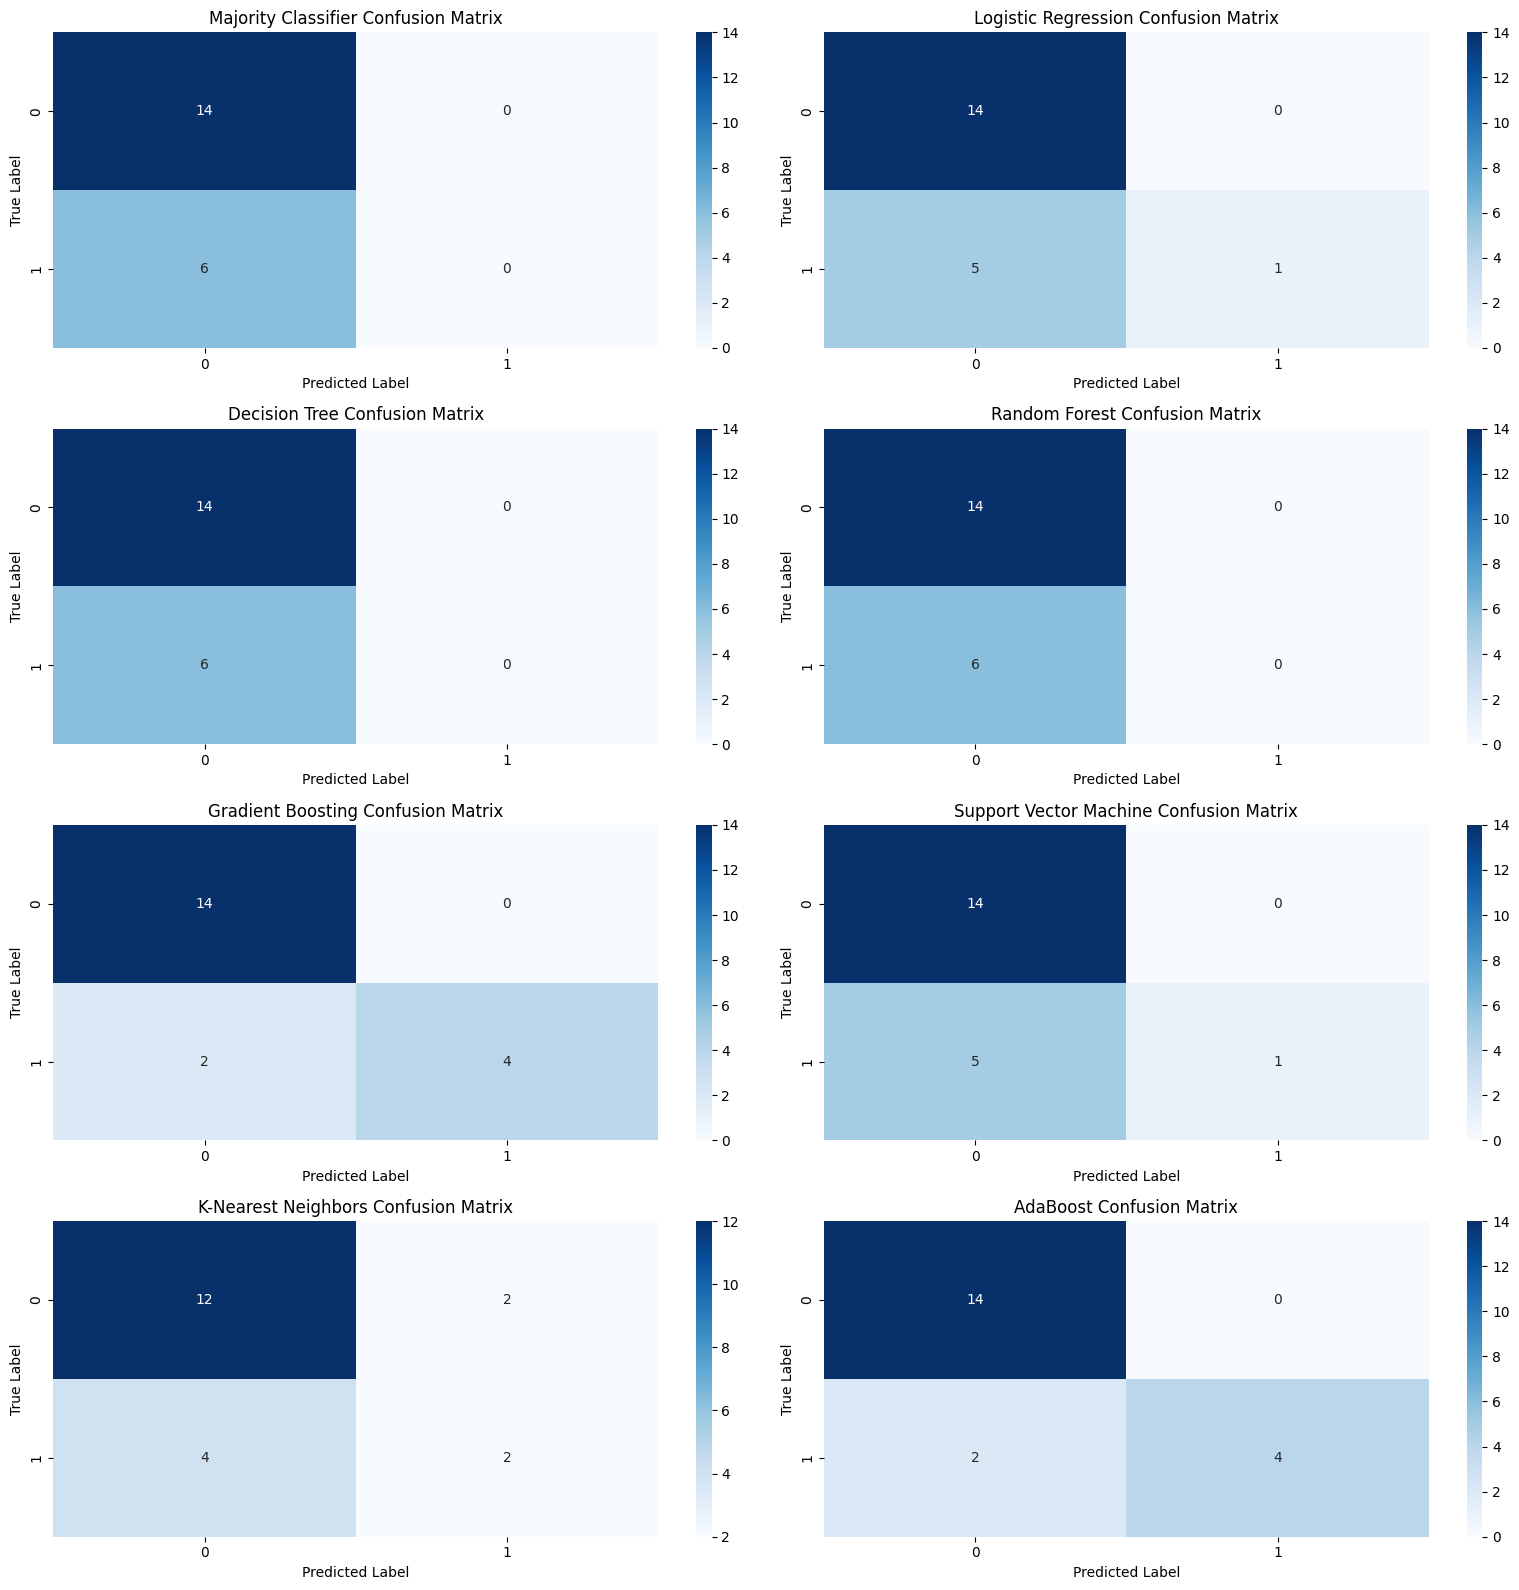

/tmp/ipykernel_35754/426578484.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_data['majority_vote'] = predicted_data[['Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']].mode(axis=1)[0]


,commercial_number,commercial_number,BDM,Logistic Regression_result,Random Forest_result,Support Vector Machine_result,majority_vote
0,AD0525,AD0525,1.0,FN,FN,FN,FN
1,AD0745,AD0745,0.0,TN,TN,TN,TN
2,AD0474,AD0474,0.0,TN,TN,TN,TN
3,AD0420,AD0420,1.0,TP,FN,TP,TP
4,AD0635,AD0635,1.0,FN,FN,FN,FN
5,AD0694,AD0694,0.0,TN,TN,TN,TN
6,AD0357,AD0357,0.0,TN,TN,TN,TN
7,AD0314,AD0314,0.0,TN,TN,TN,TN
8,AD0584,AD0584,1.0,FN,FN,FN,FN
9,AD0414,AD0414,1.0,FN,FN,FN,FN



Decision Tree Analysis:


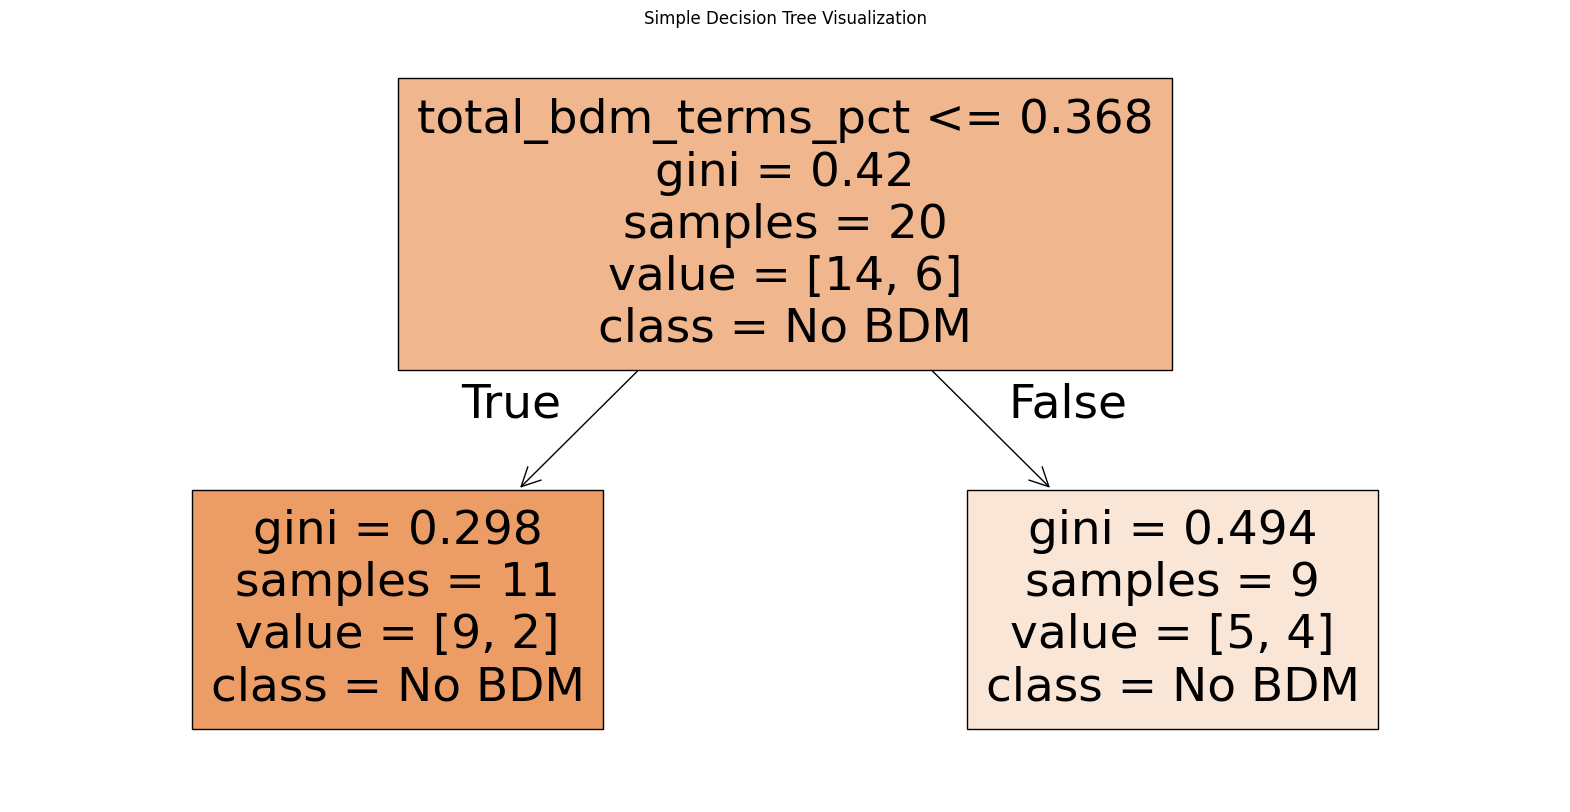


Feature Importance Ranking:
1. total_bdm_terms_pct: 1.000
2. num_adj_noun_pairs: 0.000
3. total_bdm_terms_count: 0.000
4. uniqueness_count: 0.000
5. comparative_count: 0.000
6. superlative_count: 0.000


In [184]:
import models as m

data, target = m.prepare_model_data(ad_df_balanced, INDUSTRY_SPECIFIC_AWARENESS, BRAND_SPECIFIC_AWARENESS)

base_models = m.get_base_models()
param_distributions = m.get_param_distributions()
tuned_models = m.tune_models(data, target, base_models, param_distributions)

trained_models = m.train_models(data, target, tuned_models)

# Evaluate the trained models
results_df, predictions = m.evaluate_models(data, target, trained_models)

original_data = ad_df_balanced.copy()
commercial_number = original_data['commercial_number']
display(original_data.head(10))

original_data = pd.concat([original_data, commercial_number], axis=1)

original_data = pd.concat([original_data, predictions], axis=1)

# After your existing model training code
m.display_model_results(data, target, trained_models, results_df)


predicted_data = original_data

# only include the top 3 models prediction results
predicted_data = predicted_data[['commercial_number', 'BDM', 'Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']]
# write the majority result of the colums logistic regression, random forest and support vector machine to a new column majority vote
predicted_data['majority_vote'] = predicted_data[['Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']].mode(axis=1)[0]
display(predicted_data.head(10))


m.analyze_decision_tree(data, target, tuned_models)
